# No real difference in adding in Hetionet to Deepwalk performance

Now we have to look and see just how the network changed with our addition of hetionet. If the data is hitting all the wrong places, then we expect no great increase in performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Read nodes and edges of merged network

In [3]:
nodes = pd.read_csv("data/merged_nodes.tsv", sep='\t')

In [4]:
nodes.head()

,node_uid,name,node_id,origin,sem_type
0,0,GAGE12F,100008586,hetionet,Genes & Molecular Sequences
1,1,DUXB,100033411,hetionet,Genes & Molecular Sequences
2,2,DDTL,100037417,hetionet,Genes & Molecular Sequences
3,3,OCTN3,100049579,hetionet,Genes & Molecular Sequences
4,4,POM121C,100101267,hetionet,Genes & Molecular Sequences


In [5]:
edges = pd.read_csv("data/merged_edges.tsv", sep='\t')

In [6]:
edges.head()

,final_etype,origin,source_fid,source_stype,target_fid,target_stype,source_uid,target_uid
0,REGULATES_CDreg>CD,semmeddb,UMLS:C0000039,Chemicals & Drugs,UMLS:C0001026,Chemicals & Drugs,21154,21356
1,REGULATES_CDreg>CD,semmeddb,UMLS:C0000167,Chemicals & Drugs,UMLS:C0001026,Chemicals & Drugs,21168,21356
2,PRODUCES_LBpdCD,semmeddb,UMLS:C0000901,Living Beings,UMLS:C0001026,Chemicals & Drugs,21301,21356
3,REGULATES_CDreg>CD,semmeddb,UMLS:C0000975,Chemicals & Drugs,UMLS:C0001026,Chemicals & Drugs,21332,21356
4,REGULATES_CDreg>CD,semmeddb,UMLS:C0000977,Chemicals & Drugs,UMLS:C0001026,Chemicals & Drugs,21333,21356


## How many nodes have no related edges?

Are there any nodes in our list of all nodes which have no edges in the given edge list?

Remember that the edges at the moment do not have any gold standard relations in them.

In [7]:
temp = set(edges["source_fid"]) | set(edges["target_fid"])

no_edge = set(nodes["node_id"]) - temp

In [8]:
len(no_edge)

1768

In [9]:
nodes.query("node_id in @no_edge")["origin"].value_counts()

hetionet    1755
semmeddb      13
Name: origin, dtype: int64

In [10]:
nodes.query("node_id in @no_edge")["sem_type"].value_counts()

Genes & Molecular Sequences    1742
Disorders                        16
Chemicals & Drugs                10
Name: sem_type, dtype: int64

In [11]:
nodes.query("node_id in @no_edge").head(5)

,node_uid,name,node_id,origin,sem_type
1,1,DUXB,100033411,hetionet,Genes & Molecular Sequences
3,3,OCTN3,100049579,hetionet,Genes & Molecular Sequences
7,7,KIAA1024L,100127206,hetionet,Genes & Molecular Sequences
9,9,LOC100127971,100127971,hetionet,Genes & Molecular Sequences
11,11,LOC100127991,100127991,hetionet,Genes & Molecular Sequences


Most of the nodes missing any sort of edges seem to be the more obscure genes from Entrez. These nodes are superfluous for the purposes of building the network since they are unconnected. These nodes should also be missing from hetionet since we just took the network verbatim. These nodes are inflating the original hetionet numbers.

---

## How connected are the nodes?

Build out the adjacency list for each node and examine.

In [12]:
def get_adjlist(edges):
    adjlist = defaultdict(set)

    for suid, tuid in tqdm(zip(edges["source_uid"], edges["target_uid"]),
        total=len(edges)
        ):

            adjlist[suid].add(tuid)
            adjlist[tuid].add(suid)
    
    return adjlist

In [13]:
def get_neighbours(adjlist):
    return (pd
        .DataFrame(
            [(node, len(vals)) for node, vals in adjlist.items()],
            columns = ["node_uid", "num_neighbours"]
        )
        .assign(log_neighbours = lambda df: np.log10(df["num_neighbours"]))
    )

In [14]:
sem_adj = get_adjlist(edges.query("origin == 'semmeddb'"))

100%|██████████| 9646780/9646780 [00:11<00:00, 865238.74it/s]


In [15]:
neighbours = get_neighbours(sem_adj)

Text(0,0.5,'Number of nodes')

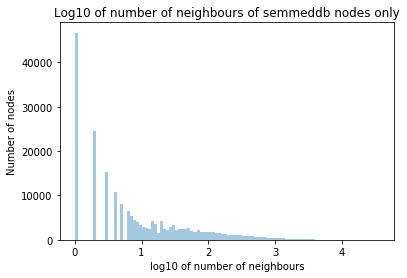

In [16]:
ax = sns.distplot(neighbours["log_neighbours"], bins=100, kde=False)
ax.set_title("Log10 of number of neighbours of semmeddb nodes only")
ax.set_xlabel("log10 of number of neighbours")
ax.set_ylabel("Number of nodes")

Text(0,0.5,'Total probability')

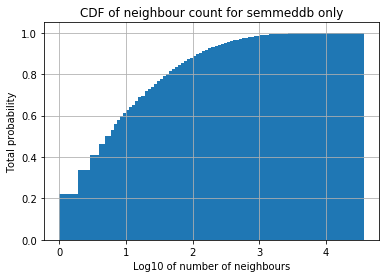

In [17]:
ax = neighbours["log_neighbours"].hist(
    cumulative=True, bins=100, density=True
)

ax.set_title("CDF of neighbour count for semmeddb only")
ax.set_xlabel("Log10 of number of neighbours")
ax.set_ylabel("Total probability")

In [18]:
neighbours["num_neighbours"].median()

5.0

The median number of neighbours per node is 5, and roughly 60% of all nodes have <= 10 neighbours. The network seems to have a vast majority of sparsely connected nodes with some extremely well connected hubs.

---

## Label the nodes and examine based on semantic type groupings

In [19]:
sem_neigh = (neighbours
    .merge(nodes, how="inner", on="node_uid")
)

In [20]:
sem_neigh.head()

,node_uid,num_neighbours,log_neighbours,name,node_id,origin,sem_type
0,21154,271,2.432969,"1,2-Dipalmitoylphosphatidylcholine",UMLS:C0000039,semmeddb,Chemicals & Drugs
1,21155,58,1.763428,"1,4-alpha-Glucan Branching Enzyme",UMLS:C0000052,semmeddb,Chemicals & Drugs
2,21156,95,1.977724,1-Carboxyglutamic Acid,UMLS:C0000084,semmeddb,Chemicals & Drugs
3,21157,608,2.783904,1-Methyl-3-isobutylxanthine,UMLS:C0000096,semmeddb,Chemicals & Drugs
4,21158,556,2.745075,"1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine",UMLS:C0000097,semmeddb,Chemicals & Drugs


Text(0,0.5,'Node semantic type')

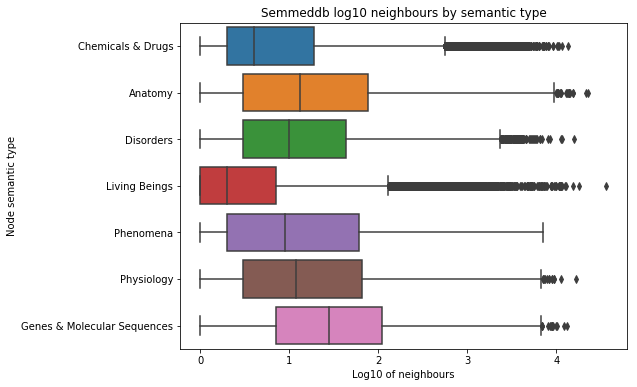

In [21]:
plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=sem_neigh, y="sem_type", x="log_neighbours")
ax.set_title("Semmeddb log10 neighbours by semantic type")
ax.set_xlabel("Log10 of neighbours")
ax.set_ylabel("Node semantic type")

## What are the top connected nodes from each category?

In [22]:
(sem_neigh
    .drop(["origin", "node_uid"], axis=1)
    .sort_values("num_neighbours", ascending=False)
    .groupby("sem_type")
    .head(10)
    .sort_values(["sem_type", "num_neighbours"], ascending=[True, False])
    .reset_index(drop=True)
)

,num_neighbours,log_neighbours,name,node_id,sem_type
0,22824,4.358392,Brain,UMLS:C0006104,Anatomy
1,21397,4.330353,Liver,UMLS:C0023884,Anatomy
2,15566,4.192177,Blood,UMLS:C0005767,Anatomy
3,15278,4.184067,Lung,UMLS:C0024109,Anatomy
4,14181,4.151707,Neurons,UMLS:C0027882,Anatomy
5,13906,4.143202,Serum,UMLS:C0229671,Anatomy
6,13899,4.142984,Heart,UMLS:C0018787,Anatomy
7,13899,4.142984,Plasma,UMLS:C0032105,Anatomy
8,13646,4.135005,Kidney,UMLS:C0022646,Anatomy
9,13040,4.115278,Membrane,UMLS:C0596901,Anatomy


mostly your standard generic concepts at the top of the connectivity tree. not super informative so far.

---

## Compare networks when we add in hetionet edges

In [23]:
all_adj = get_adjlist(edges)

100%|██████████| 12294467/12294467 [00:15<00:00, 793297.60it/s]


In [24]:
all_neigh = get_neighbours(all_adj)

Text(0,0.5,'Number of nodes')

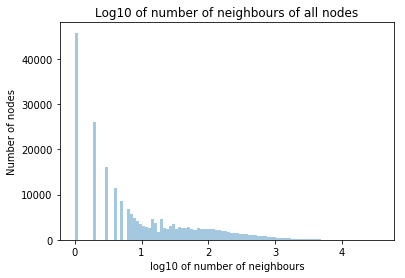

In [25]:
ax = sns.distplot(all_neigh["log_neighbours"], bins=100, kde=False)
ax.set_title("Log10 of number of neighbours of all nodes")
ax.set_xlabel("log10 of number of neighbours")
ax.set_ylabel("Number of nodes")

Text(0,0.5,'Total probability')

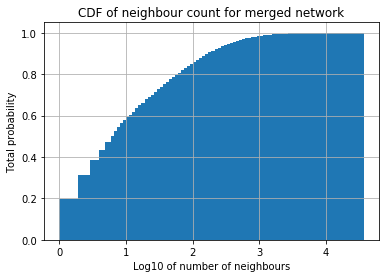

In [26]:
ax = all_neigh["log_neighbours"].hist(
    cumulative=True, bins=100, density=True
)

ax.set_title("CDF of neighbour count for merged network")
ax.set_xlabel("Log10 of number of neighbours")
ax.set_ylabel("Total probability")

In [27]:
all_neigh["num_neighbours"].median()

6.0

In [28]:
lab_neigh = (all_neigh
    .merge(nodes, how="inner", on="node_uid")
)

In [29]:
lab_neigh.head()

,node_uid,num_neighbours,log_neighbours,name,node_id,origin,sem_type
0,0,1,0.000000,GAGE12F,100008586,hetionet,Genes & Molecular Sequences
1,2,25,1.397940,DDTL,100037417,hetionet,Genes & Molecular Sequences
2,4,89,1.949390,POM121C,100101267,hetionet,Genes & Molecular Sequences
3,5,69,1.838849,ZSCAN30,100101467,hetionet,Genes & Molecular Sequences
4,6,61,1.785330,TMEM170B,100113407,hetionet,Genes & Molecular Sequences


Text(0,0.5,'Node semantic type')

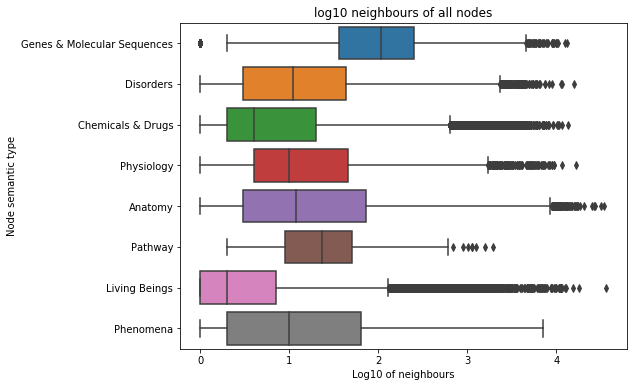

In [30]:
plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=lab_neigh, y="sem_type", x="log_neighbours")

ax.set_title("log10 neighbours of all nodes")
ax.set_xlabel("Log10 of neighbours")
ax.set_ylabel("Node semantic type")

While interesting, we don't really care too much about the absolute number of neighbours of each subgraph. We are more interested in how the additional edges changed the overall graph.

---

## Which nodes had their neighbours changed?

In [31]:
full_counts = (lab_neigh
    .rename(columns={
        "num_neighbours": "num_all",
        "log_neighbours": "log_all"
    })
    .merge(
        sem_neigh[["node_uid", "num_neighbours", "log_neighbours"]],
        how="left", on="node_uid"
    )
    .rename(columns={
        "num_neighbours": "num_sem",
        "log_neighbours": "log_sem"
    })
    .fillna(value={"num_sem": 0})
    .assign(num_sem = lambda df: df["num_sem"].astype(int))
)

In [32]:
full_counts.head()

,node_uid,num_all,log_all,name,node_id,origin,sem_type,num_sem,log_sem
0,0,1,0.000000,GAGE12F,100008586,hetionet,Genes & Molecular Sequences,0,NaN
1,2,25,1.397940,DDTL,100037417,hetionet,Genes & Molecular Sequences,0,NaN
2,4,89,1.949390,POM121C,100101267,hetionet,Genes & Molecular Sequences,0,NaN
3,5,69,1.838849,ZSCAN30,100101467,hetionet,Genes & Molecular Sequences,0,NaN
4,6,61,1.785330,TMEM170B,100113407,hetionet,Genes & Molecular Sequences,0,NaN


In [33]:
full_counts.shape

(229775, 9)

In [34]:
len(full_counts.query("num_sem == 0")) / len(full_counts) * 100

8.443042106408443

The number of new nodes added to semmeddb which actually have some number of edges is roughly 8% of the size of the final network.

## Which nodes changed?

In [35]:
len(full_counts.query("num_sem > 0 and num_all != num_sem")) / len(full_counts) * 100

11.46991622239147

Only 11% of the nodes which already existed in semmeddb had their neighbour counts increase after we integrated hetionet. This is not a very large portion of the network, but we do need to keep in mind that hetionet only had around 50000 nodes in total, so the maximum possible percentage achieveable here is only around 25%.

In [36]:
changed = (full_counts
    .query("num_all != num_sem")
    .assign(increase = lambda df: df["num_all"].subtract(df["num_sem"]))
    .assign(log_d = lambda df: np.log10(df["increase"]))
)

In [37]:
changed.shape

(45755, 11)

In [38]:
changed.head()

,node_uid,num_all,log_all,name,node_id,origin,sem_type,num_sem,log_sem,increase,log_d
0,0,1,0.000000,GAGE12F,100008586,hetionet,Genes & Molecular Sequences,0,NaN,1,0.000000
1,2,25,1.397940,DDTL,100037417,hetionet,Genes & Molecular Sequences,0,NaN,25,1.397940
2,4,89,1.949390,POM121C,100101267,hetionet,Genes & Molecular Sequences,0,NaN,89,1.949390
3,5,69,1.838849,ZSCAN30,100101467,hetionet,Genes & Molecular Sequences,0,NaN,69,1.838849
4,6,61,1.785330,TMEM170B,100113407,hetionet,Genes & Molecular Sequences,0,NaN,61,1.785330


## Absolute change in neighbours for existing semmeddb nodes

Text(0,0.5,'Nodes changed')

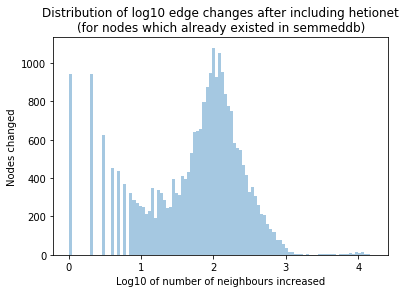

In [39]:
ax = sns.distplot(changed.query("num_sem > 0")["log_d"], kde=False, bins=100)

ax.set_title("Distribution of log10 edge changes after including hetionet\n"
    "(for nodes which already existed in semmeddb)"
)
ax.set_xlabel("Log10 of number of neighbours increased")
ax.set_ylabel("Nodes changed")

## Relative change

In [40]:
temp = (changed
    .query("num_sem > 0")
    .assign(log_ratio = lambda df: df["log_all"].subtract(df["log_sem"]))
)

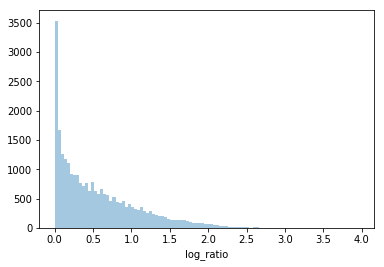

In [41]:
sns.distplot(temp["log_ratio"], kde=False, bins=100)

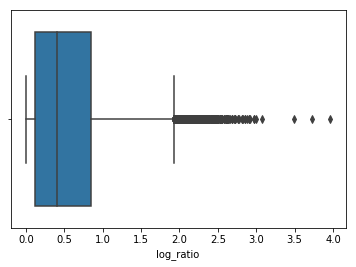

In [42]:
sns.boxplot(temp["log_ratio"])

In [43]:
10**(temp["log_ratio"].median())

2.546511627906978

The median change in relative number of neighbours is 2.5x, which is a substantial change.

---

### relative change in neighbour count as a function of original neighbour count

Text(0.5,0.98,'Relative change in neighbours as a function of neighbour count')

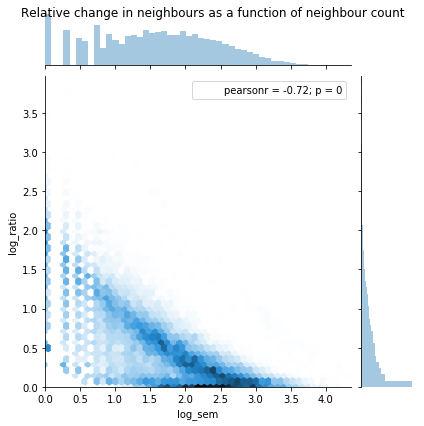

In [44]:
ax = sns.jointplot(
    data=temp, x="log_sem", y="log_ratio", kind="hex"
)

ax.fig.suptitle("Relative change in neighbours as a function of neighbour count")

---

### relative change in size by category

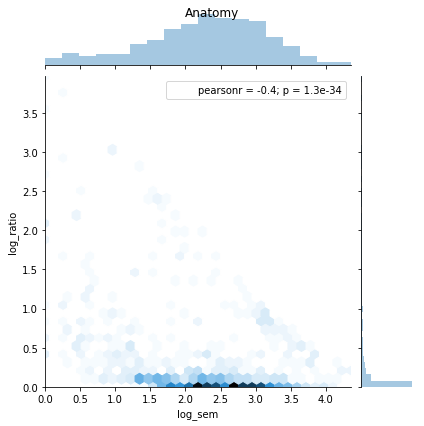

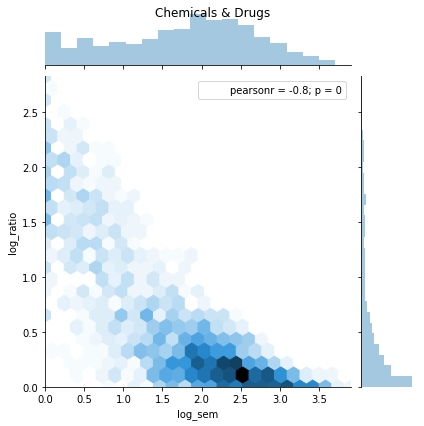

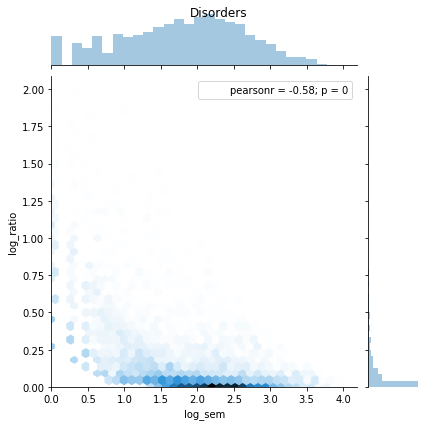

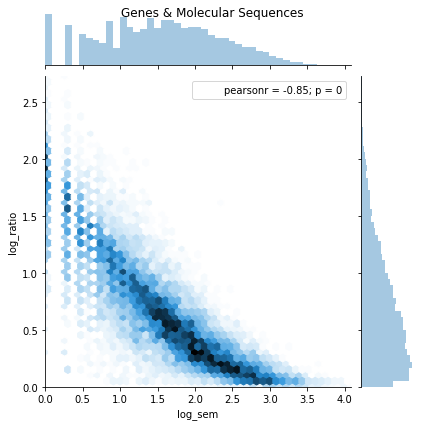

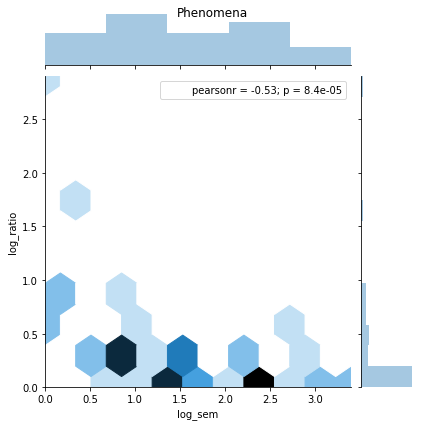

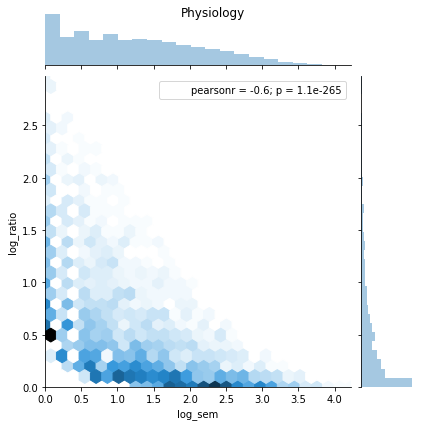

In [45]:
for semtype, df in temp.groupby("sem_type"):
    if len(df) > 1:
        ax = sns.jointplot(
            data=df, x="log_sem", y="log_ratio", kind="hex"
        )

        ax.fig.suptitle(semtype)

Anatomy and disorder nodes do not seem to have more information added for the low information nodes, which is a correlation we observe for all the other node types.

### newly added nodes

In [46]:
changed.query("num_sem == 0")["sem_type"].value_counts()

Physiology                     11581
Genes & Molecular Sequences     3172
Pathway                         1822
Disorders                       1472
Anatomy                         1035
Chemicals & Drugs                318
Name: sem_type, dtype: int64

### Existing nodes

In [47]:
changed.query("num_sem > 0")["sem_type"].value_counts()

Genes & Molecular Sequences    15970
Disorders                       4782
Physiology                      2711
Chemicals & Drugs               1972
Anatomy                          870
Phenomena                         49
Living Beings                      1
Name: sem_type, dtype: int64

Text(0.5,1,'Log10 change in number of neighbours for semmeddb nodes by category')

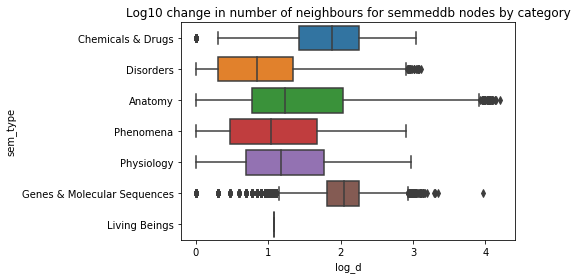

In [48]:
ax = sns.boxplot(data=changed.query("num_sem > 0"), x="log_d", y="sem_type")

ax.set_title("Log10 change in number of neighbours for semmeddb nodes by category")

Text(0.5,1,'Log10 of (adj final / adj start) for semmeddb nodes by category')

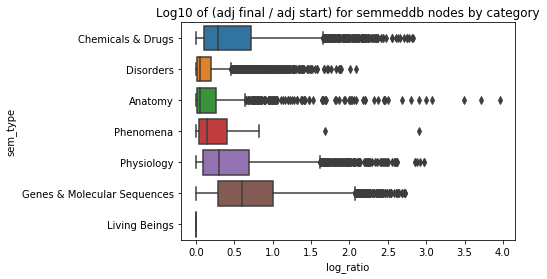

In [49]:
ax = sns.boxplot(data=temp, x="log_ratio", y="sem_type")

ax.set_title("Log10 of (adj final / adj start) for semmeddb nodes by category")

This above plot tells us how much effect we had in relative terms, not absolute terms. It seems that the disorders and phenomena had similar absolute changes, but the phenomena had less information, and experienced greater relative change.

---

## Were the changed nodes related to the gold standard at all

In [50]:
gold = pd.read_csv("data/merged_gold.tsv", sep='\t')

In [51]:
gold.shape

(6329, 7)

In [52]:
gold.head()

,chemical_id,chemical_name,disease_id,disease_name,etype,chemical_uid,disease_uid
0,UMLS:C0520442,acetyldigitoxin,UMLS:C0004238,Atrial fibrillation,TREATS_CDtDO,108642,22585
1,UMLS:C0033497,propranolol,UMLS:C0004238,Atrial fibrillation,TREATS_CDtDO,32398,22585
2,UMLS:C0012265,digoxin,UMLS:C0004238,Atrial fibrillation,TREATS_CDtDO,25280,22585
3,UMLS:C0084273,quinidine,UMLS:C0004238,Atrial fibrillation,TREATS_CDtDO,55039,22585
4,UMLS:C0766326,dronedarone,UMLS:C0004238,Atrial fibrillation,TREATS_CDtDO,134609,22585


In [53]:
temp = set(gold["chemical_id"]) | set(gold["disease_id"])

gold_nodes = full_counts.query("node_id in @temp")

In [54]:
gold_nodes.shape

(2567, 9)

In [55]:
gold_nodes.head()

,node_uid,num_all,log_all,name,node_id,origin,sem_type,num_sem,log_sem
19457,21212,293,2.466868,4-Aminobenzoic Acid,UMLS:C0000473,semmeddb,Chemicals & Drugs,293,2.466868
19458,21213,612,2.786751,4-Aminopyridine,UMLS:C0000477,semmeddb,Chemicals & Drugs,530,2.724276
19470,21225,1206,3.081347,Eicosapentaenoic Acid,UMLS:C0000545,semmeddb,Chemicals & Drugs,1169,3.067815
19479,21234,394,2.595496,6-Mercaptopurine,UMLS:C0000618,semmeddb,Chemicals & Drugs,328,2.515874
19522,21277,3,0.477121,Incomplete spontaneous abortion,UMLS:C0000810,semmeddb,Disorders,3,0.477121


### Gold nodes with no change in neighbours

In [56]:
gold_nodes.query("num_sem == num_all").shape

(1077, 9)

In [57]:
len(gold_nodes.query("num_sem == num_all")) / len(gold_nodes) * 100

41.95559018309311

around 1000 of the gold standard nodes (41%) had no change in the number of neighbours they had when hetionet was added to semmeddb

41% of the gold standard concepts saw no increase in the number of neighbours (most likely because the added edges lost their semantic meanings when being converted for deepwalk).

In [58]:
gold_nodes.query("num_sem == num_all")["sem_type"].value_counts()

Chemicals & Drugs    699
Disorders            376
Living Beings          2
Name: sem_type, dtype: int64

---

In [59]:
gold_diff = (gold_nodes
    .assign(increase = lambda df: df["num_all"].subtract(df["num_sem"]))
)

In [60]:
gold_diff.head()

,node_uid,num_all,log_all,name,node_id,origin,sem_type,num_sem,log_sem,increase
19457,21212,293,2.466868,4-Aminobenzoic Acid,UMLS:C0000473,semmeddb,Chemicals & Drugs,293,2.466868,0
19458,21213,612,2.786751,4-Aminopyridine,UMLS:C0000477,semmeddb,Chemicals & Drugs,530,2.724276,82
19470,21225,1206,3.081347,Eicosapentaenoic Acid,UMLS:C0000545,semmeddb,Chemicals & Drugs,1169,3.067815,37
19479,21234,394,2.595496,6-Mercaptopurine,UMLS:C0000618,semmeddb,Chemicals & Drugs,328,2.515874,66
19522,21277,3,0.477121,Incomplete spontaneous abortion,UMLS:C0000810,semmeddb,Disorders,3,0.477121,0


Text(0.5,1,'Log10 change in number of neighbours for gold standard nodes')

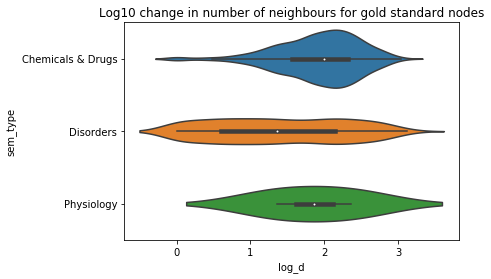

In [61]:
ax = sns.violinplot(
    data=gold_diff.query("increase > 0").assign(log_d = lambda df: np.log10(df["increase"])),
    x="log_d", y="sem_type"
)

ax.set_title("Log10 change in number of neighbours for gold standard nodes")

Text(0.5,1,'Log10 change in number of neighbours for gold standard nodes')

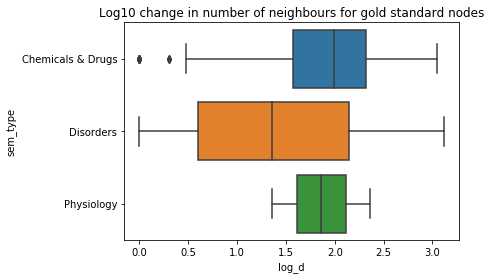

In [62]:
ax = sns.boxplot(
    data=gold_diff.query("increase > 0").assign(log_d = lambda df: np.log10(df["increase"])),
    x="log_d", y="sem_type"
)

ax.set_title("Log10 change in number of neighbours for gold standard nodes")

---

### What was the relative change in number of neighbours for gold standard concepts?

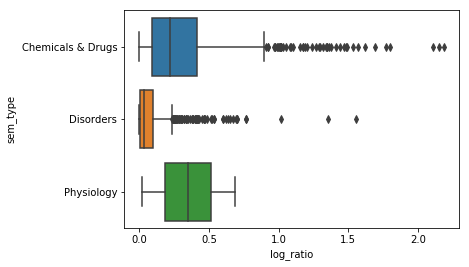

In [63]:
temp = (gold_diff
    .query("num_all > num_sem")
    .assign(log_ratio = lambda df: df["log_all"] - df["log_sem"])
)

sns.boxplot(data=temp, x="log_ratio", y="sem_type")

In [64]:
temp.groupby("sem_type")["log_ratio"].median().apply(lambda v: 10**v)

sem_type
Chemicals & Drugs    1.666667
Disorders            1.078455
Physiology           2.244697
Name: log_ratio, dtype: float64

The percent change for diseases is really low at only 7%. Chemicals fare a bit better at 66% increase, and physiology does the best at a 2.2x increase. Overall though the change in connectivity is a bit disappointing, and may explain why we are not seeing changes in performance for deepwalk.